In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from Bayesian2 import BayesianLinearRegression

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,02 SLB,7.0,191.0,2022-1,30.77,0.000000,...,35.914865,0.856748,0.000000,0,0,0,0,-3.025000,28.012944,NaN
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,02 SLB,7.0,192.0,2022-1,48.22,30.770000,...,35.799613,1.103224,0.243718,0,0,0,0,-0.279167,32.898193,NaN
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,02 SLB,7.0,193.0,2022-1,30.53,39.495000,...,35.684360,1.023044,-0.083744,0,0,0,0,2.033333,36.760487,NaN
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,02 SLB,7.0,194.0,2022-1,42.26,36.506667,...,35.569108,1.066796,0.040438,0,0,0,0,0.066667,31.939524,NaN
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,02 SLB,7.0,195.0,2022-1,38.49,37.945000,...,35.453856,1.073339,0.003074,0,0,0,0,-3.700000,26.498206,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483097,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,41 Fjällko,10.0,347.0,2023-3,12.67,14.652000,...,13.608593,1.030966,-0.045706,0,1,0,0,12.666667,53.132530,NaN
483098,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,41 Fjällko,10.0,348.0,2023-3,22.31,14.030000,...,13.516773,1.108549,0.070579,0,1,0,0,13.079167,56.726870,NaN
483099,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,41 Fjällko,10.0,349.0,2023-3,12.84,14.984000,...,13.424952,1.109278,-0.006853,0,1,0,0,14.237500,58.482418,NaN
483100,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,41 Fjällko,10.0,350.0,2023-3,9.47,14.892000,...,13.333131,1.095617,-0.021300,0,1,0,0,15.345833,60.546358,NaN


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.897593,1.007414
1,2022-2,0.900378,1.006885
2,2022-3,0.904556,1.007751
3,2022-4,0.890449,1.008684
4,2023-1,0.882515,1.009232
5,2023-2,0.877435,1.009570
6,2023-3,0.881014,1.009432
7,2023-4,0.877632,1.009315


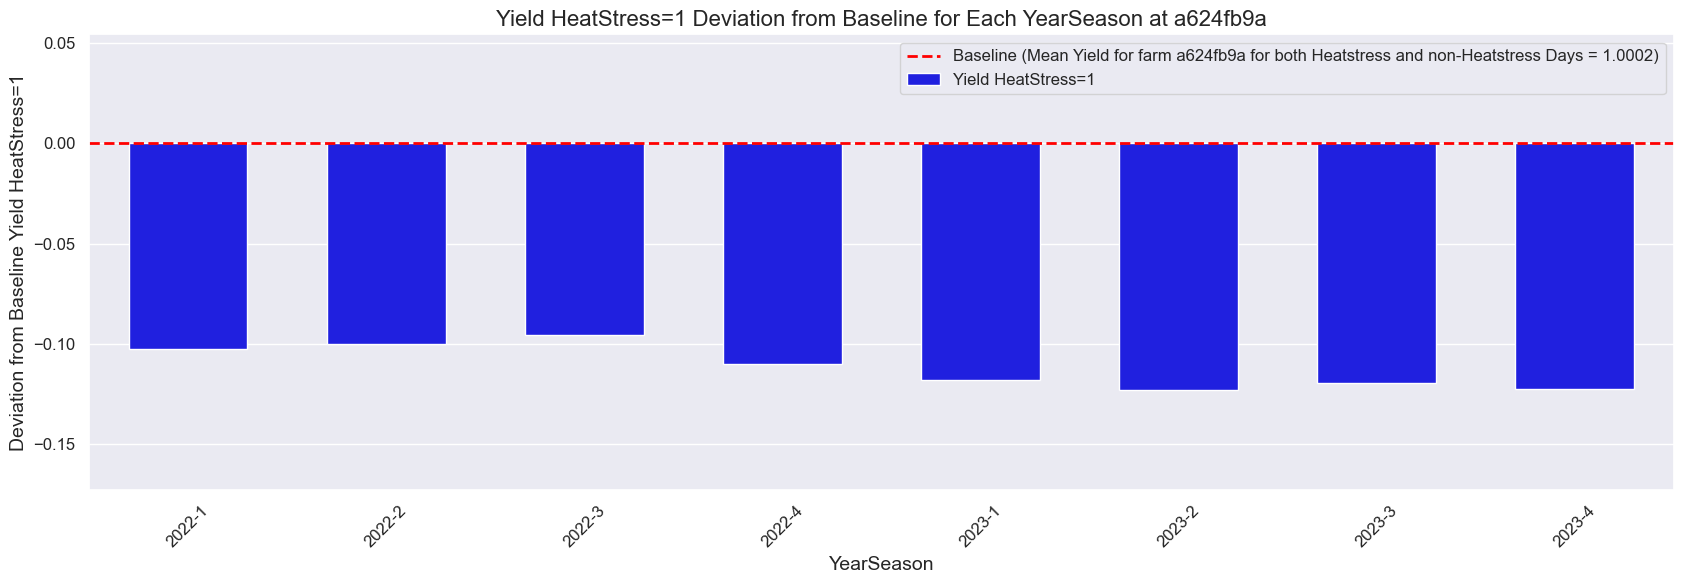

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.05, max(results_df['Deviation from Baseline HeatStress=1']) + 0.15)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

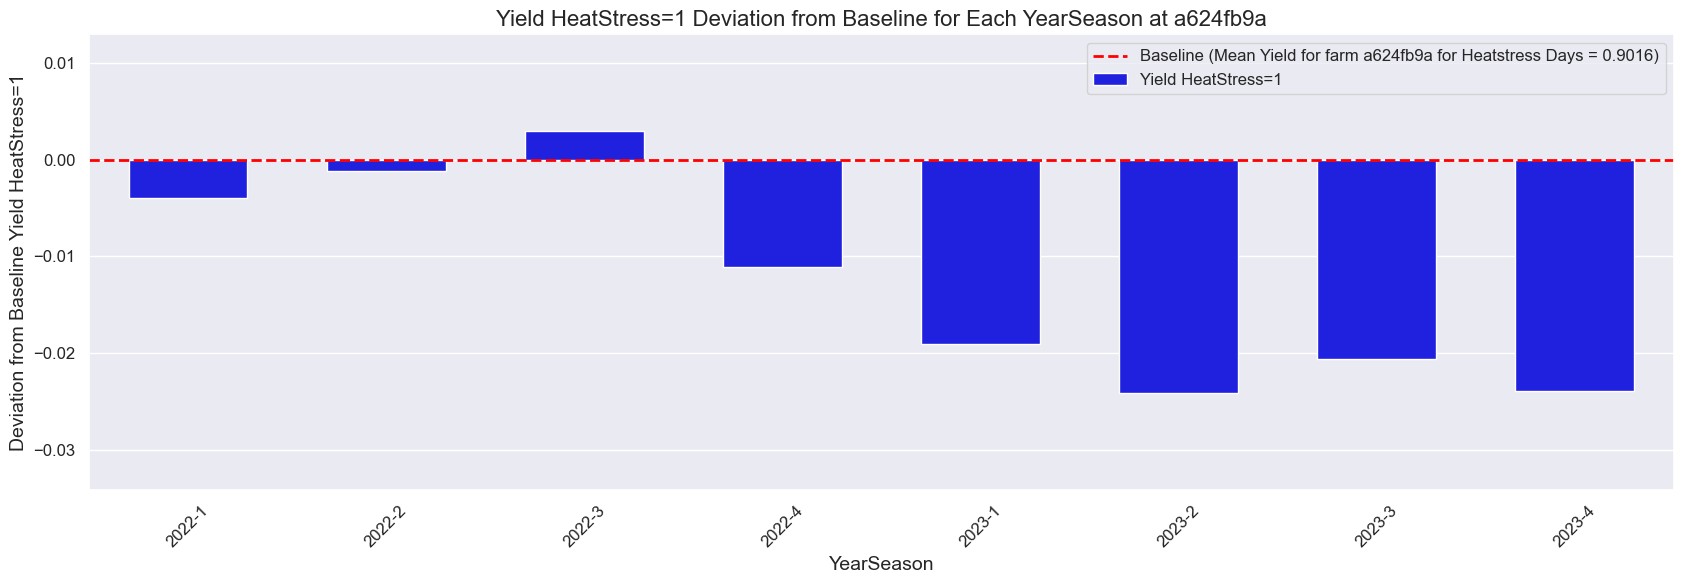

In [5]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm 5c06d92d

In [6]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.929361,1.003694
1,2022-2,0.927599,1.003643
2,2022-3,0.929145,1.003252
3,2022-4,0.929951,1.003196
4,2023-1,0.928041,1.003450
5,2023-2,0.925740,1.003501
6,2023-3,0.925791,1.003203
7,2023-4,0.925689,1.002878


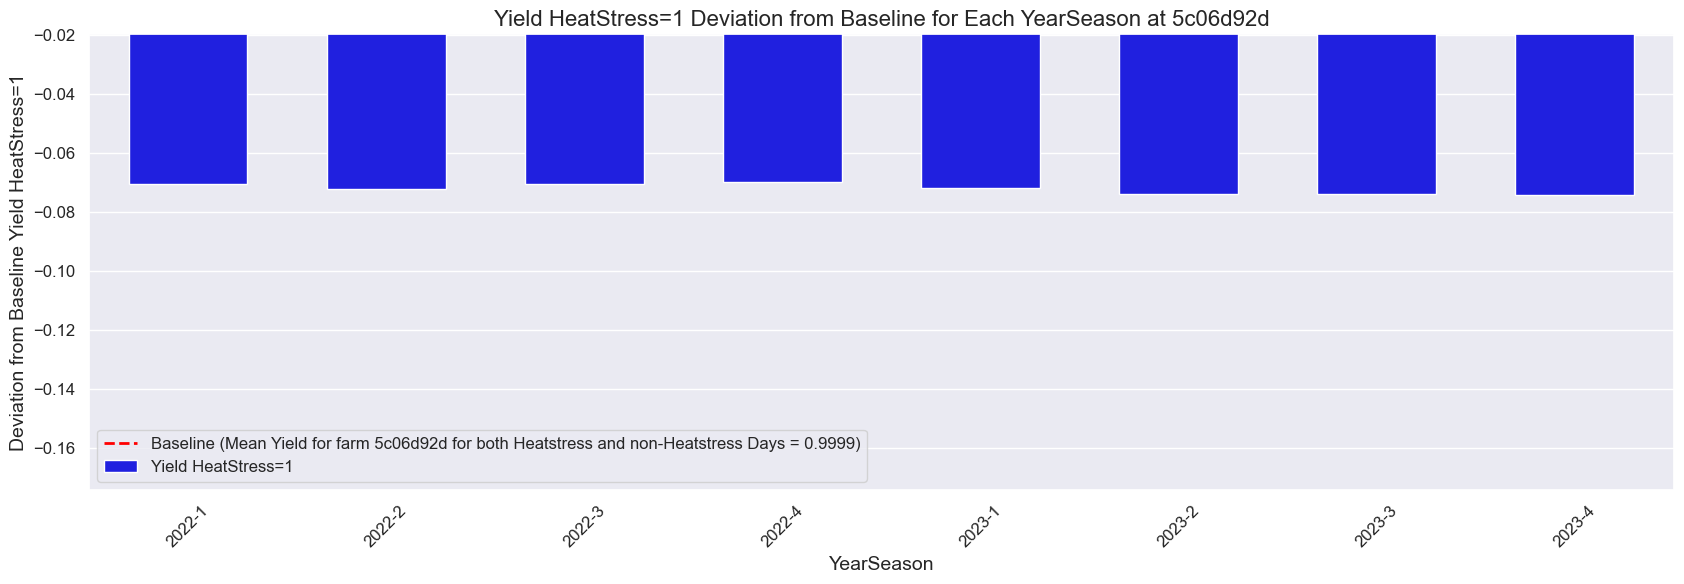

In [7]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.1, max(results_df['Deviation from Baseline HeatStress=1']) + 0.05)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

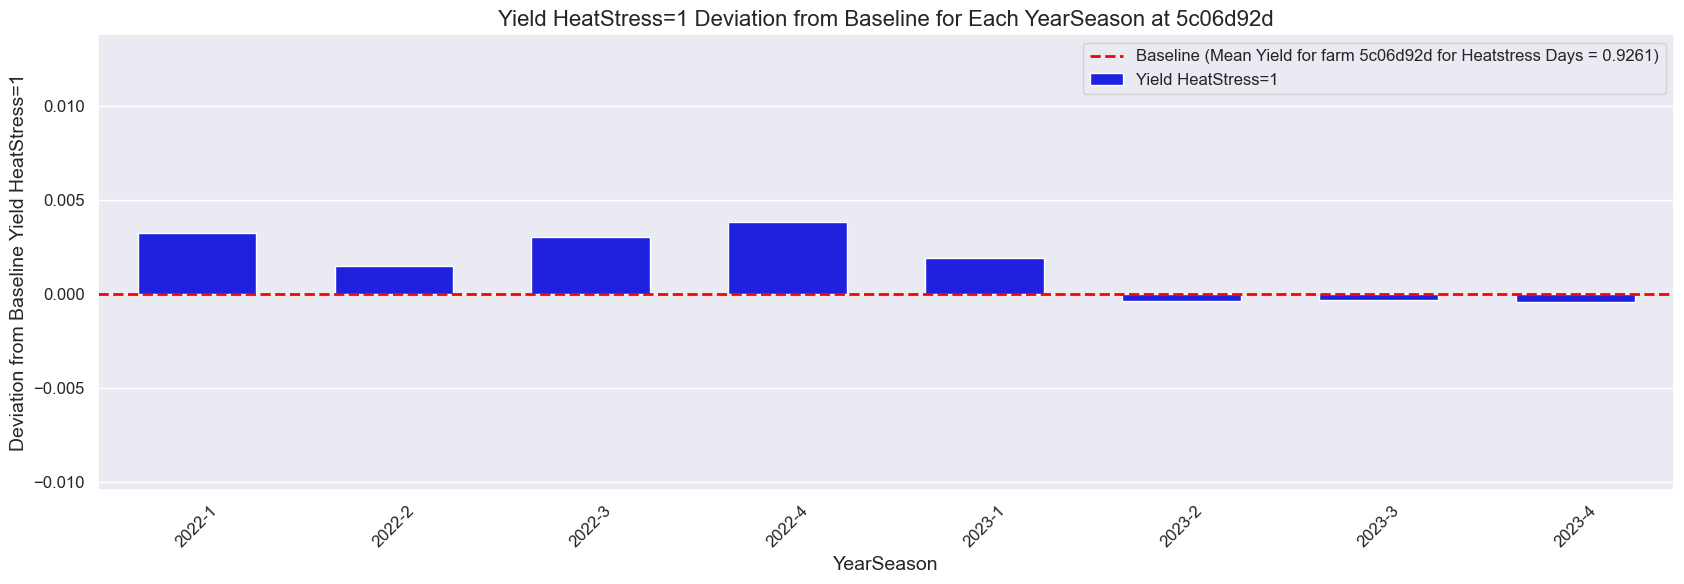

In [8]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm 752efd72

In [9]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.933598,1.005180
1,2022-2,0.937179,1.007302
2,2022-3,0.937199,1.007525
3,2022-4,0.937993,1.007130
4,2023-1,0.936655,1.005483
5,2023-2,0.933934,1.007061
6,2023-3,0.935321,1.008641
7,2023-4,0.934148,1.006875


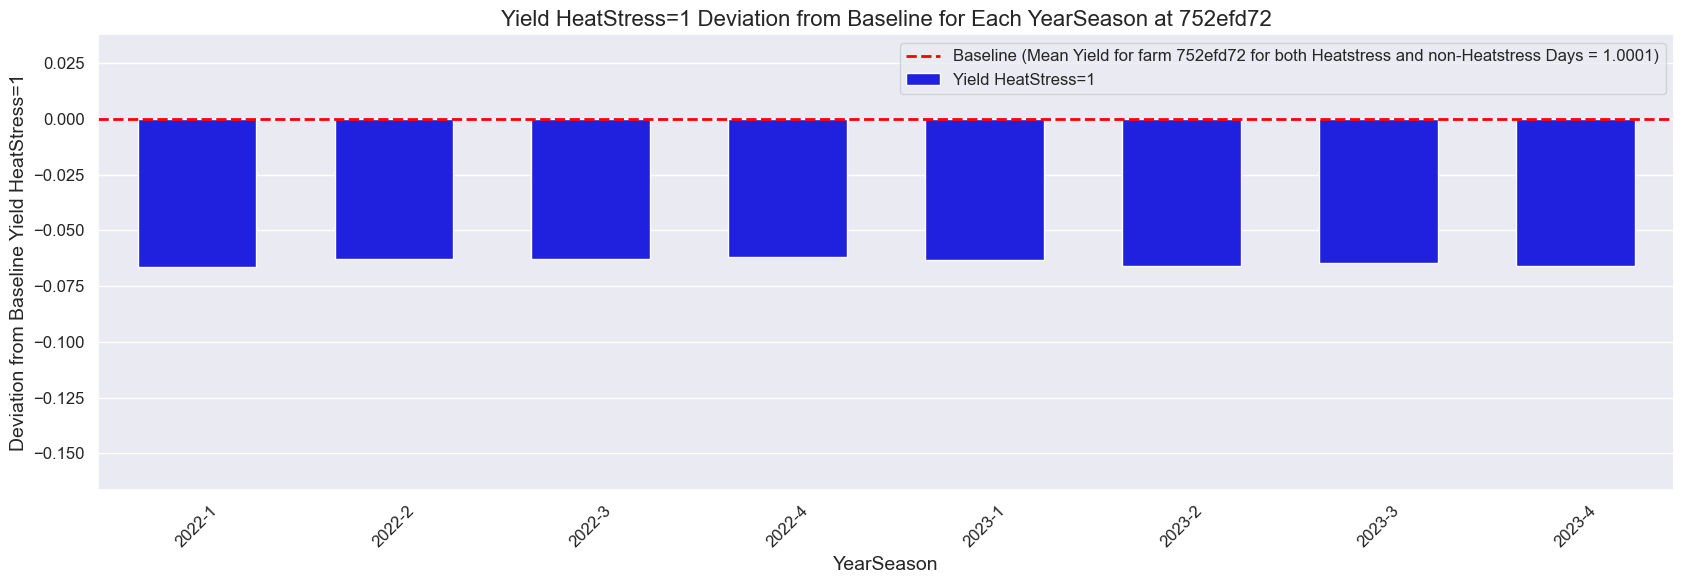

In [10]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.1, max(results_df['Deviation from Baseline HeatStress=1']) + 0.1)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

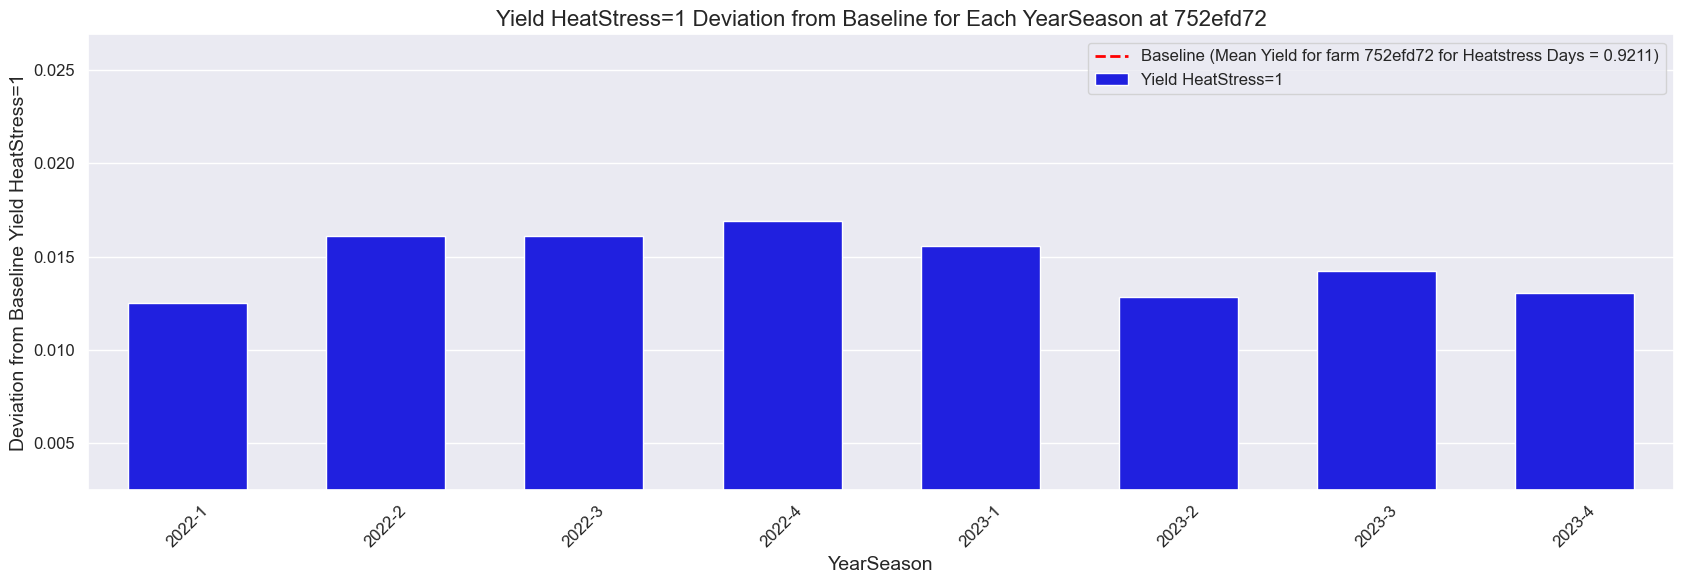

In [11]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Farm f454e660

In [12]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
daily_farm_data['MeanTemperature'] = scaler.fit_transform(daily_farm_data[['MeanTemperature']])

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Filter data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0].copy()

# Fit the model and calculate yield changes for all cows for HeatStress=1
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature)

# Fit the model and calculate yield changes for all cows for HeatStress=0
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature)

# Create results DataFrame for HeatStress=1
results_df_1 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_1.keys(),
    'Yield HeatStress=1': yield_changes_heatstress_1.values()
})

# Create results DataFrame for HeatStress=0
results_df_0 = pd.DataFrame({
    'SE_Number': yield_changes_heatstress_0.keys(),
    'Yield HeatStress=0': yield_changes_heatstress_0.values()
})

# Merge yield changes with the original data to get YearSeason for each cow
results_df_1 = results_df_1.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')
results_df_0 = results_df_0.merge(daily_farm_data[['SE_Number', 'YearSeason']].drop_duplicates(), on='SE_Number', how='left')

# Group by YearSeason and calculate the mean Yield HeatStress for both conditions
results_df_1 = results_df_1.groupby('YearSeason').agg({'Yield HeatStress=1': 'mean'}).reset_index()
results_df_0 = results_df_0.groupby('YearSeason').agg({'Yield HeatStress=0': 'mean'}).reset_index()

# Merge the two results DataFrames on YearSeason
results_df = results_df_1.merge(results_df_0, on='YearSeason', how='outer')

# Display the results DataFrame
results_df

,YearSeason,Yield HeatStress=1,Yield HeatStress=0
0,2022-1,0.952859,0.999949
1,2022-2,0.954156,0.999811
2,2022-3,0.952544,0.999657
3,2022-4,0.955669,0.999722
4,2023-1,0.968518,0.999263
5,2023-2,0.975996,0.997116
6,2023-3,0.985291,0.996168
7,2023-4,0.979070,0.995916


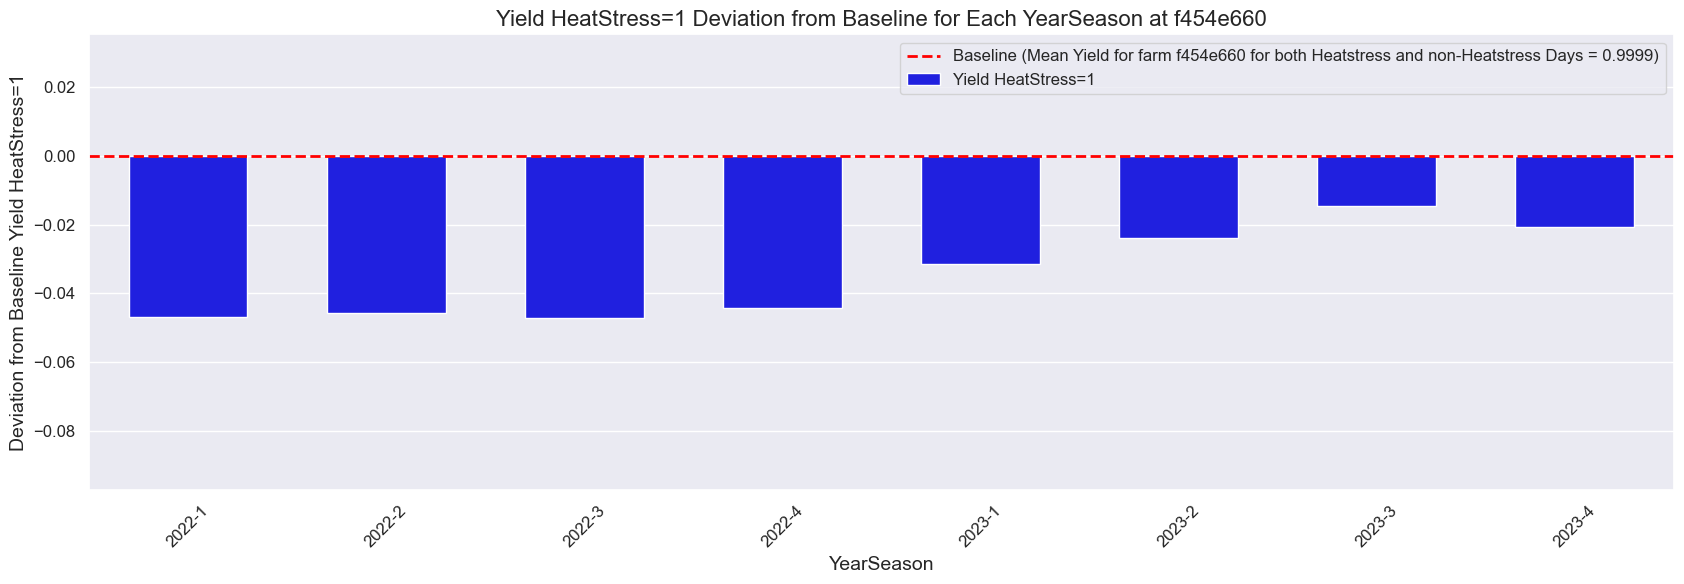

In [13]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.05, max(results_df['Deviation from Baseline HeatStress=1']) + 0.05)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

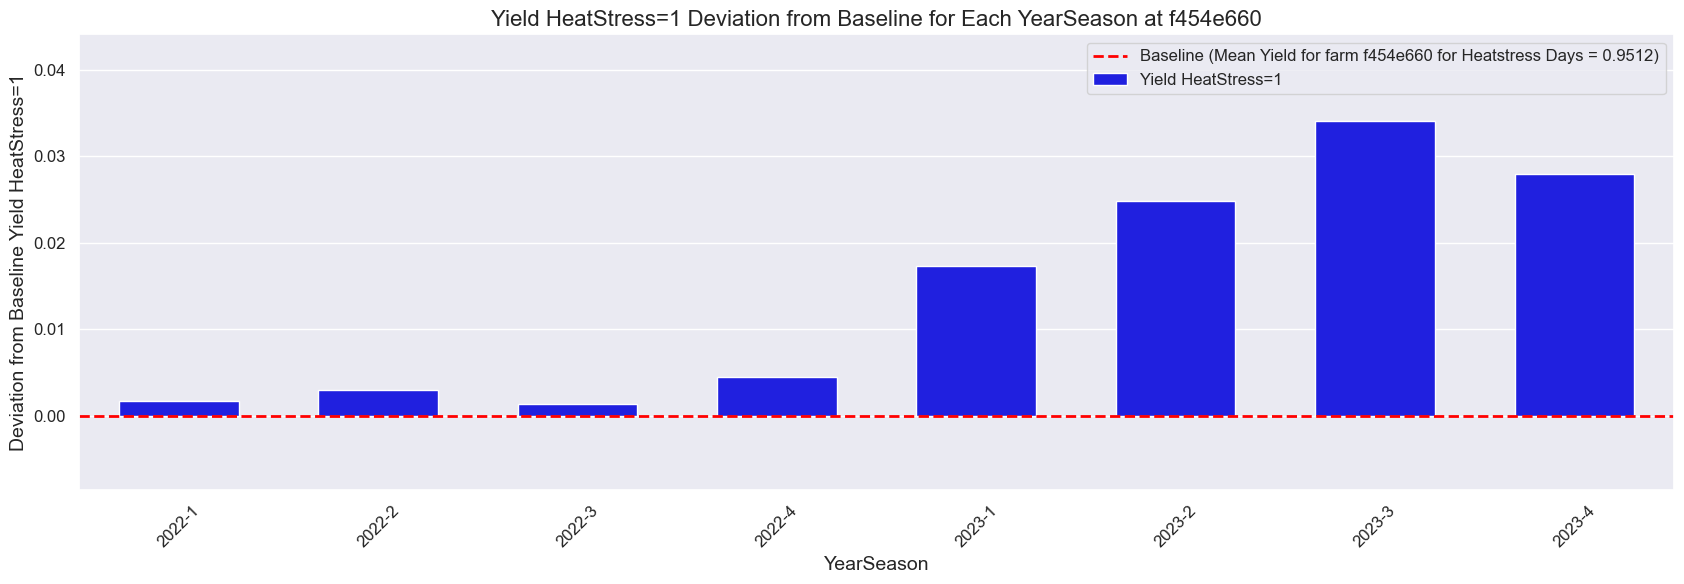

In [14]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline for HeatStress=1
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', data=results_df, color='blue', label='Yield HeatStress=1', width=0.6)

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('YearSeason', fontsize=14)
plt.ylabel('Deviation from Baseline Yield HeatStress=1', fontsize=14)
plt.title(f'Yield HeatStress=1 Deviation from Baseline for Each YearSeason at {farm}', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Adjust the limits to zoom out and show more of the positive y-values
plt.ylim(min(results_df['Deviation from Baseline HeatStress=1']) - 0.01, max(results_df['Deviation from Baseline HeatStress=1']) + 0.01)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()